In [10]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import joblib

In [19]:
PATH=os.getcwd()

mod="CAE"
rep='spec'

trainRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'TrainResults.pkl'
testRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'TestResults.pkl'
trainRes=pd.read_pickle(trainRes_path)
testRes=pd.read_pickle(testRes_path)

results=pd.DataFrame({utter:{'test_loss':0, 'test_acc':0, 'tstSpk_data':{}} for utter in testRes.columns})
div=max(testRes.index)[0]+1

for item in testRes:
    for index in testRes.index:
        if index[1] == 'tstSpk_data':
            results[item][index[1]].update(testRes[item][index])
        else:
            results[item][index[1]]+=testRes[item][index]/div


(0, 1)

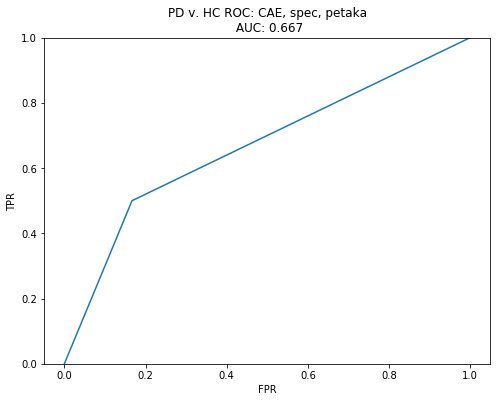

In [26]:
roc_dic={thrsh*.01:{'tp':0,'fp':0,'tn':0,'fn':0} for thrsh in np.arange(101)}
tprs=[]
fprs=[]
utter='petaka'

for itr,(index, col) in enumerate(results.items()):
    if col.name==utter:
        tprs=[]
        fprs=[]
        ax=axs[itr]
        for thresh in roc_dic.items():
            thr=thresh[0]
    #         if col.name==utter:
    #             for epoch in range(n_epochs):
            for key,value in enumerate(list(results[index]['tstSpk_data'].values())):
                if value == {}:
                    value=0
                if key<50 and value>thr:
                    roc_dic[thr]['tp']+=1
                if key<50 and value<thr:
                    roc_dic[thr]['fn']+=1
                if key>=50 and value>thr:
                    roc_dic[thr]['fp']+=1
                if key>=50 and value<thr:
                    roc_dic[thr]['tn']+=1

            tprs.append(roc_dic[thr]['tp']/(roc_dic[thr]['tp']+roc_dic[thr]['fn']+10e-6))
            fprs.append(roc_dic[thr]['fp']/(roc_dic[thr]['fp']+roc_dic[thr]['tn']+10e-6))


tprs=np.sort(tprs)
fprs=np.sort(fprs)
fig,ax=plt.subplots(1,1,figsize=(8, 6))
plt.plot(np.sort(fprs),np.sort(tprs))
plt.title("PD v. HC ROC: "+mod+", "+rep+", "+utter+"\n AUC: "+str(np.round(metrics.auc(fprs, tprs),3)))
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_xlim([-.05,1.05])
ax.set_ylim([0,1])

In [14]:
# roc_dic={thrsh*.01:{'tp':0,'fp':0,'tn':0,'fn':0} for thrsh in np.arange(101)}
# tprs=[]
# fprs=[]
# fig,axs=plt.subplots(2,3,figsize=(12, 8))
# axs = axs.ravel()
# utter='petaka'

# for itr,(index, col) in enumerate(results.items()):
#     if col.name==utter:
#         tprs=[]
#         fprs=[]
#         ax=axs[itr]
#         for thresh in roc_dic.items():
#             thr=thresh[0]
#     #         if col.name==utter:
#     #             for epoch in range(n_epochs):
#             for key,value in enumerate(list(results[index]['tstSpk_data'].values())):
#                 if value == {}:
#                     value=0
#                 if key<50 and value>thr:
#                     roc_dic[thr]['tp']+=1
#                 if key<50 and value<thr:
#                     roc_dic[thr]['fn']+=1
#                 if key>=50 and value>thr:
#                     roc_dic[thr]['fp']+=1
#                 if key>=50 and value<thr:
#                     roc_dic[thr]['tn']+=1

#             tprs.append(roc_dic[thr]['tp']/(roc_dic[thr]['tp']+roc_dic[thr]['fn']+10e-6))
#             fprs.append(roc_dic[thr]['fp']/(roc_dic[thr]['fp']+roc_dic[thr]['tn']+10e-6))

#         ax.plot(np.sort(fprs),np.sort(tprs))
#         ax.set_title("PD v. HC ROC: "+mod+", "+rep+", "+index+"\n AUC: "+str(np.round(metrics.auc(fprs, tprs),3)))
#         ax.set_xlabel("FPR")
#         ax.set_ylabel("TPR")
#         ax.set_xlim([-.05,1.05])
#         ax.set_ylim([0,1])
#         plt.tight_layout()
    

In [21]:
print('MEAN % of FRAMES CLASSIFIED PD')
for key,item in results.items():
    print(key+' - ', 'pd: '+str(np.round(np.mean([itm for k,itm in item['tstSpk_data'].items() if k<50]),3)), 'hc: '+str(np.round(np.mean([itm for k,itm in item['tstSpk_data'].items() if k>=50]),3)))


MEAN % of FRAMES CLASSIFIED PD
pataka -  pd: 0.594 hc: 0.571


TypeError: unsupported operand type(s) for +: 'float' and 'dict'

In [ ]:
# for key,item in results.items():
#     print(key,item['test_acc'])

In [ ]:
# n_epochs=results.iloc[-1].name[0]
# utters=['pataka','kakaka','pakata','papapa','petaka','tatata']

# col_res={ut:{key:0 for key in results.loc[0].index} for ut in utters}

# for index, col in results.items():
#     col_res[col.name]['tstSpk_data']={num:0 for num in np.arange(100)}
#     col_res[col.name]['test_accPerSpk']=0

#     for epoch in range(n_epochs):
#         col_res[col.name]['train_loss']+=col.loc[epoch]['train_loss']*(1/n_epochs)
#         col_res[col.name]['test_loss']+=col.loc[epoch]['test_loss']*(1/n_epochs)
#         col_res[col.name]['train_acc']+=col.loc[epoch]['train_acc']*(1/n_epochs)
#         col_res[col.name]['test_acc']+=col.loc[epoch]['test_acc']*(1/n_epochs)

#         for key,value in col.loc[epoch]['tstSpk_data'].items():   
# #             if value>=.5:
# #                 col_res[col.name]['test_accPerSpk']+=(1/(100*n_epochs))       
#             col_res[col.name]['tstSpk_data'][key]+=value*(1/n_epochs)
    